# IUPred - implementation


In this project I was implementing the IUPred predictor in a clean Pythonic way... as far as I could.

In [140]:
import pandas as pd
import sys
from collections import defaultdict
import statistics

In [5]:
def save_output(
    data : pd.DataFrame, 
    iupred_type: str, 
    outfile : str = None) -> None:
    '''There is a fixed header printed on all the output + the tsv of the output.
    '''
    header = ('# IUPred2A: context-dependent prediction of protein disorder as a function of redox state and protein binding\n'
    "# Balint Meszaros, Gabor Erdos, Zsuzsanna Dosztanyi\n"
    "# Nucleic Acids Research 2018;46(W1):W329-W337.\n"
    "#\n"
    f"# Prediction type: {iupred_type}\n"
    "# Prediction output\n")
    
    # Output is directed either to a file or to the standard output:
    if outfile:
        with open(outfile, 'w') as f:
                f.write(header)
                data.to_csv(f, sep='\t', index=False)
    else:
        print(header + df.to_csv(sep='\t', index=False))
    
    return None

In [21]:
def read_fasta(fasta_file: str) -> dict:
    '''This function returns with a dictionary of the sequences in a fasta file. the keys are the header row'''
    sequences = {}

    with open(fasta_file) as f:
        for line in f:
            # Found a header:
            if line.startswith(">"):
                key = line.strip()
                sequences[key] = ''

            # Add rows to a given header:
            else:
                sequences[key] += line.strip()
    
    return sequences


seqence = read_fasta('single.fasta')
seq = list(seqence.values())[0]
seq

'MNRHLWKSQLCEMVQPSGGPAADQDVLGEESPLGKPAMLHLPSEQGAPETLQRCLEENQELRDAIRQSNQILRERCEELLHFQASQREEKEFLMCKFQEARKLVERLGLEKLDLKRQKEQALREVEHLKRCQQQMAEDKASVKAQVTSLLGELQESQSRLEAATKECQALEGRARAASEQARQLESEREALQQQHSVQVDQLRMQGQSVEAALRMERQAASEEKRKLAQLQVAYHQLFQEYDNHIKSSVVGSERKRGMQLEDLKQQLQQAEEALVAKQEVIDKLKEEAEQHKIVMETVPVLKAQADIYKADFQAERQAREKLAEKKELLQEQLEQLQREYSKLKASCQESARIEDMRKRHVEVSQAPLPPAPAYLSSPLALPSQRRSPPEEPPDFCCPKCQYQAPDMDTLQIHVMECIE'

In [7]:
# from collections import defaultdict

def aa_freq(_seq):
    _freq = defaultdict(int)
    for _aa in _seq:
        _freq[_aa] += 1
    
    for _aa, _ins in _freq.items():
        _freq[_aa] = _ins / len(_seq)
    return _freq

def read_matrix(matrix_file):
    _mtx = defaultdict(defaultdict)
    with open(matrix_file, "r") as _fhm:
        for _line in _fhm:
            (_aa1, _aa2, _val) = _line.split()
            _mtx[_aa1][_aa2] = float(_val)

    return _mtx


# read_matrix('/Users/dsuveges/Downloads/iupred2a/data/iupred2_long_energy_matrix')
def read_histo(histo_file):
    hist = []
    vals = []

    with open(histo_file, "r") as fnh:
        for _line in fnh:
            if _line.startswith("#"):
                continue
                
            vals.append(float(_line.split()[1]))
            hist.append(float(_line.split()[-1]))
            
    h_max = max(vals)
    h_min = min(vals)
    h_step = (h_max - h_min) / (len(hist))
    return hist, h_min, h_max, h_step

(hist, h_min, h_max, h_step) = read_histo('/Users/dsuveges/Downloads/iupred2a/data/long_histogram')

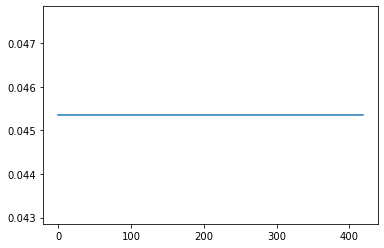

In [179]:
class iupred2a(object):
    
    PATH = '/Users/dsuveges/repositories/iupred2a/data'

    def __init__(self, iupred_type='long'):
        
        # Validating iupred method:
        if iupred_type not in ['long', 'short', 'glob']:
            raise TypeError(f'Unknown prediction type: {iupred_type}. Supported types: "long", "short", "glob"')
            
        self.method = iupred_type
        self.lc = 1
        
        if iupred_type == "short":
            self.uc = 25
            self.wc = 10
            matrix_file = f"{self.PATH}/iupred2_short_energy_matrix"
            histogram_file = f"{self.PATH}/short_histogram"

        elif iupred_type == 'glob':
            self.uc = 100
            self.wc = 15

        elif iupred_type == 'long':
            self.uc = 100
            self.wc = 10

        if iupred_type == 'long' or iupred_type == 'glob':
            matrix_file = f"{self.PATH}/iupred2_long_energy_matrix"
            histogram_file = f"{self.PATH}/long_histogram"            
            
        self.matrix = self.read_matrix(matrix_file)
        (self.histogram, self.histogram_min, self.histogram_max, self.histogram_step) = read_histo(histogram_file)

    @staticmethod
    def read_matrix(matrix_file):
        _mtx = defaultdict(defaultdict)
        with open(matrix_file, "r") as _fhm:
            for _line in _fhm:
                (_aa1, _aa2, _val) = _line.split()
                _mtx[_aa1][_aa2] = float(_val)

        return _mtx


    @staticmethod
    def read_histo(histo_file):
        hist = []
        vals = []

        with open(histo_file, "r") as fnh:
            for _line in fnh:
                if _line.startswith("#"):
                    continue

                vals.append(float(_line.split()[1]))
                hist.append(float(_line.split()[-1]))

        h_max = max(vals)
        h_min = min(vals)
        h_step = (h_max - h_min) / (len(hist))
        return hist, h_min, h_max, h_step       
    
    
    @staticmethod
    def aa_freq(_seq):
        _freq = defaultdict(int)
        for _aa in _seq:
            _freq[_aa] += 1

        for _aa, _ins in _freq.items():
            _freq[_aa] = _ins / len(_seq)
        return _freq
    
    
    @staticmethod
    def smooth(energy_list, window):
        weighted_energy_score = [0] * len(energy_list)
        for idx in range(len(energy_list)):
            weighted_energy_score[idx] = statistics.mean(energy_list[max(0, idx - window):min(len(energy_list),idx + window + 1)])
        return weighted_energy_score
    
    def calculate_iupred_score(self):
        iupred_score = [0] * len(self.weighted_energy_score)
        for idx, val in enumerate(self.weighted_energy_score):
            if val <= self.histogram_min + 2 * self.histogram_step:
                iupred_score[idx] = 1
            elif val >= self.histogram_max - 2 * self.histogram_step:
                iupred_score[idx] = 0
            else:
                iupred_score[idx] = self.histogram[int((weighted_energy_score[idx] - self.histogram_min) * (1 / self.histogram_step))]

        return iupred_score
    
    def predict(self, seq):
        self.unweighted_energy_score = self.calculate_unweighted_energy_score(seq)
        self.weighted_energy_score = self.calculate_weighted_energy_score(seq)
        iupred_score = self.calculate_iupred_score()
        return iupred_score
        
    def calculate_weighted_energy_score(self, seq):
        weighted_energy_score = [0] * len(seq)
        if self.method == 'short':
            for idx in range(len(seq)):
                for idx2 in range(idx - self.wc, idx + self.wc + 1):
                    if idx2 < 0 or idx2 >= len(seq):
                        weighted_energy_score[idx] += -1.26
                    else:
                        weighted_energy_score[idx] += self.unweighted_energy_score[idx2]
                weighted_energy_score[idx] /= len(range(idx - self.wc, idx + self.wc + 1))
        else:
            weighted_energy_score = self.smooth(self.unweighted_energy_score, self.wc)

        return weighted_energy_score
        
    def calculate_unweighted_energy_score(self, seq):
        unweighted_energy_score = [0] * len(seq)
        for idx in range(len(seq)):
            freq_dct = self.aa_freq(seq[max(0, idx - self.uc):max(0, idx - self.lc)] + seq[idx + self.lc + 1:idx + self.uc + 1])
            for aa, freq in freq_dct.items():
                unweighted_energy_score[idx] += mtx[seq[idx]][aa] * freq
        return unweighted_energy_score
        
iu = iupred2a('long')
pd.Series(iu.predict(seq),  name='iupred').plot()

In [123]:
unweighted_energy_score = [0] * len(seq)
for idx in range(len(seq)):
    freq_dct = aa_freq(seq[max(0, idx - uc):max(0, idx - lc)] + seq[idx + lc + 1:idx + uc + 1])
    for aa, freq in freq_dct.items():
        unweighted_energy_score[idx] += mtx[seq[idx]][aa] * freq

In [177]:
iupred = iu.predict(seq)
type(iupred)

[0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352, 0.045352,

NoneType

In [71]:
idx = 100
seq_chunk = seq[max(0, idx - uc):max(0, idx - lc)] + seq[idx + lc + 1:idx + uc + 1]
print(len(seq_chunk))
frec_dict = aa_freq(seq[max(0, idx - uc):max(0, idx - lc)] + seq[idx + lc + 1:idx + uc + 1])

48


In [115]:
matrix = pd.read_csv('/Users/dsuveges/repositories/iupred2a/data/iupred2_long_energy_matrix', sep=' ', names=['ref','neighbour','energy'])

# unweighted_energy_score[idx] = (
#     matrix.loc[matrix.ref==seq[idx]]
#     .apply(lambda x: frec_dict[x['lookup']] * x['energy'] if x['lookup'] in frec_dict else 0, axis=1)
#     .sum()
# )

In [108]:
unweighted_energy_score[idx] = 0
for aa, freq in frec_dict.items():
    unweighted_energy_score[idx] += mtx[seq[idx]][aa] * freq
    
unweighted_energy_score[idx]

0.38993978416666686

In [180]:
seq

'MNRHLWKSQLCEMVQPSGGPAADQDVLGEESPLGKPAMLHLPSEQGAPETLQRCLEENQELRDAIRQSNQILRERCEELLHFQASQREEKEFLMCKFQEARKLVERLGLEKLDLKRQKEQALREVEHLKRCQQQMAEDKASVKAQVTSLLGELQESQSRLEAATKECQALEGRARAASEQARQLESEREALQQQHSVQVDQLRMQGQSVEAALRMERQAASEEKRKLAQLQVAYHQLFQEYDNHIKSSVVGSERKRGMQLEDLKQQLQQAEEALVAKQEVIDKLKEEAEQHKIVMETVPVLKAQADIYKADFQAERQAREKLAEKKELLQEQLEQLQREYSKLKASCQESARIEDMRKRHVEVSQAPLPPAPAYLSSPLALPSQRRSPPEEPPDFCCPKCQYQAPDMDTLQIHVMECIE'